## Pets Expression Classification Using:
### DenseNet121

### Importing The Necessary Libraries:

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import kagglehub

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, AveragePooling2D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping



c:\Users\Seif\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Downloading the Dataset from kaggle and Storing them in a local folder

In [2]:
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

path_2 = os.path.join(path, "Master Folder")

train_dir = os.path.join(path, "Master Folder", "train")
val_dir = os.path.join(path, "Master Folder", "valid")
test_dir = os.path.join(path, "Master Folder", "test")

Path to dataset files: C:\Users\Seif\.cache\kagglehub\datasets\anshtanwar\pets-facial-expression-dataset\versions\11


In this section, the training, validation, and test datasets are prepared for training a DenseNet121 model. Images are resized to **224x224**, which matches the input size expected by DenseNet121.

- **Training Data Augmentation:** To improve generalization and prevent overfitting, various augmentation techniques are applied using `ImageDataGenerator`:
  - Rescaling pixel values to the `[0, 1]` range
  - Random rotations (up to 30°)
  - Random zooms, horizontal flips, and shifts in width and height
  - Shearing and filling strategy for transformed areas
  
- **Validation and Test Sets:** These are only rescaled (no augmentation) to ensure consistent evaluation.

- **Data Generators:**
  - `train_gen` loads and augments training images.
  - `val_gen` loads validation images for monitoring during training.
  - `test_gen` loads test images for final evaluation, with `shuffle=False` to maintain label order for metrics like confusion matrix.

This setup ensures the model sees varied data during training while being evaluated fairly on clean validation/test sets.


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


### Building the DenseNet121 Model

In this section, the **DenseNet121** architecture from Keras Applications is used for pet facial expression classification.

- **Weights:** `weights=None` ensures the model is initialized from scratch (not using pre-trained ImageNet weights), suitable when training on a custom dataset.
- **Input Shape:** Set to `(224, 224, 3)` to match the preprocessed image dimensions.
- **Number of Classes:** The output layer has 4 neurons (for 4 pet expression categories) with softmax activation.

This built-in implementation provides a reliable, optimized baseline to compare with any custom DenseNet121 models built from scratch.

In [4]:
from tensorflow.keras.applications import DenseNet121

# Builtin Model for Comparison
builtin_model = DenseNet121(weights=None, input_shape=(224, 224, 3), classes=4)
builtin_model.summary()


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 6,957,956 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

### Custom DenseNet121 Implementation

This section defines a custom implementation of the **DenseNet121** architecture, built from scratch using TensorFlow/Keras layers.

Key Components:
- **Convolution Block (`conv_block`)**: Implements the bottleneck structure with a `1x1` followed by a `3x3` convolution, each preceded by Batch Normalization and ReLU activation. The output is concatenated with the input to enable dense connectivity.
- **Dense Block (`dense_block`)**: A stack of `conv_block`s, with the number of layers determined by the `block_config` parameter.
- **Transition Layer (`transition_layer`)**: Reduces the number of feature maps using a `1x1` convolution followed by `2x2` average pooling, with optional compression.
- **DenseNet121_Custom Model**:
  - Begins with a `7x7` convolution and max pooling.
  - Follows the DenseNet121 layout: `[6, 12, 24, 16]` layers in the four dense blocks.
  - Ends with batch normalization, ReLU, global average pooling, and a softmax classification layer.

This model is flexible and allows experimentation with growth rates, compression factors, and dataset-specific configurations.

In [ ]:
def conv_block(x, growth_rate):
    # Bottleneck layer: BN-ReLU-1x1 Conv
    x1 = BatchNormalization()(x)
    x1 = ReLU()(x1)
    x1 = Conv2D(4 * growth_rate, kernel_size=1, strides=1, padding='same', use_bias=False)(x1)
    
    # BN-ReLU-3x3 Conv
    x1 = BatchNormalization()(x1)
    x1 = ReLU()(x1)
    x1 = Conv2D(growth_rate, kernel_size=3, strides=1, padding='same', use_bias=False)(x1)
    
    # Concatenate with input (dense connection)
    x = Concatenate()([x, x1])
    return x

def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        x = conv_block(x, growth_rate)
    return x

def transition_layer(x, compression=0.5):
    # BN-ReLU-1x1 Conv
    x = BatchNormalization()(x)
    x = ReLU()(x)
    out_channels = int(tf.keras.backend.int_shape(x)[-1] * compression)
    x = Conv2D(out_channels, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    # Avg Pool
    x = AveragePooling2D(pool_size=2, strides=2, padding='same')(x)
    return x

def DenseNet121_Custom(input_shape=(224, 224, 3), num_classes=7, growth_rate=32):
    # Configuration from paper: 6, 12, 24, 16
    block_config = [6, 12, 24, 16]

    inputs = Input(shape=input_shape)

    # Initial Convolution and Pooling
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)


    # Dense Blocks with Transition Layers
    for i in range(len(block_config)):
        x = dense_block(x, block_config[i], growth_rate)
        if i != len(block_config) - 1:
            x = transition_layer(x)

    # Final BN, ReLU, Global Pooling
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling2D()(x)

    # Classification layer
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs, name="DenseNet121_custom")

In [11]:
model = DenseNet121_Custom(input_shape=(224, 224, 3), num_classes=4)
model.summary()

Model: "DenseNet121_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 112, 112,  │      9,408 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_120[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_121 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu_121[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_122 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 56, 56,    │      8,192 │ re_lu_122[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_121[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_123 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 56, 56,    │     36,864 │ re_lu_123[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_58      │ (None, 56, 56,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_122[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ concatenate_58[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_124 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 56, 56,    │     12,288 │ re_lu_124[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_123[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_125 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 6,957,956 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [12]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### Model Training

The compiled DenseNet121 model is trained on the pet facial expression dataset using the preprocessed and augmented training data on 20 epochs.

- **Training Generator:** `train_gen` provides augmented batches of training images.
- **Validation Generator:** `val_gen` is used to evaluate the model’s performance on unseen validation data after each epoch.
- **Epochs:** The model is trained for 20 epochs.

This training process helps the model learn to distinguish between the 4 classes of pet expressions by minimizing the categorical crossentropy loss and improving classification accuracy.

In [14]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 180s 6s/step - accuracy: 0.4085 - loss: 1.2753 - val_accuracy: 0.2500 - val_loss: 1.4395
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 182s 6s/step - accuracy: 0.4122 - loss: 1.2630 - val_accuracy: 0.2500 - val_loss: 1.5048
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 184s 6s/step - accuracy: 0.4747 - loss: 1.1891 - val_accuracy: 0.2500 - val_loss: 1.6036
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 180s 6s/step - accuracy: 0.4678 - loss: 1.1749 - val_accuracy: 0.1667 - val_loss: 1.6762
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 182s 6s/step - accuracy: 0.5640 - loss: 1.0712 - val_accuracy: 0.3056 - val_loss: 1.4297
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.5262 - loss: 1.0878 - val_accuracy: 0.2778 - val_loss: 1.5264
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 182s 6s/step - accuracy: 0.5601 - loss: 1.0088 - val_accuracy: 0.2500 - val_loss: 1.5960
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.6290 - loss: 0.9457 - val_accuracy: 0.2222 - v

### Model Evaluation on Test Data

After training, the model is evaluated on the test set to measure its generalization performance.

- **Predictions:** The model predicts class probabilities for each test image using `model.predict()`, and the predicted class labels are obtained using `np.argmax`.
- **True Labels:** Ground truth labels are extracted directly from the `test_gen`.

#### Evaluation Metrics:
- **Classification Report:** Displays precision, recall, F1-score, and accuracy for each class using `classification_report` from `sklearn.metrics`. It helps assess performance per class.
- **Confusion Matrix:** A confusion matrix is plotted using Seaborn to visualize how well the model distinguishes between each expression category.
  - Rows represent **true labels**, and columns represent **predicted labels**.
  - Helps identify where the model is confusing one class for another.

This evaluation provides both a numerical and visual understanding of the model's strengths and weaknesses on the test data.

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step
              precision    recall  f1-score   support

       Angry     0.2308    0.3000    0.2609        10
       Other     0.0714    0.1667    0.1000         6
         Sad     0.2857    0.1818    0.2222        11
       happy     0.5000    0.1818    0.2667        11

    accuracy                         0.2105        38
   macro avg     0.2720    0.2076    0.2124        38
weighted avg     0.2995    0.2105    0.2260        38



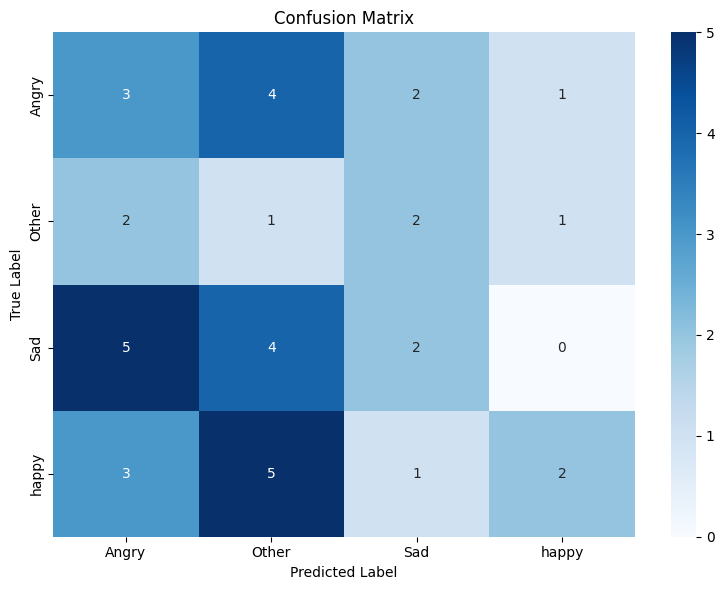

In [15]:
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [16]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 267s 8s/step - accuracy: 0.8188 - loss: 0.5285 - val_accuracy: 0.3889 - val_loss: 3.2229
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 280s 9s/step - accuracy: 0.8112 - loss: 0.4816 - val_accuracy: 0.3611 - val_loss: 2.9403
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 229s 7s/step - accuracy: 0.8626 - loss: 0.4394 - val_accuracy: 0.3889 - val_loss: 2.9788
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 313s 10s/step - accuracy: 0.8659 - loss: 0.3718 - val_accuracy: 0.3333 - val_loss: 2.9585
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 230s 7s/step - accuracy: 0.8382 - loss: 0.4510 - val_accuracy: 0.3333 - val_loss: 3.7978
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 231s 7s/step - accuracy: 0.8507 - loss: 0.3946 - val_accuracy: 0.3611 - val_loss: 4.2954
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 317s 10s/step - accuracy: 0.8609 - loss: 0.3803 - val_accuracy: 0.3611 - val_loss: 2.6237
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 256s 8s/step - accuracy: 0.8514 - loss: 0.4074 - val_accuracy: 0.2500 -

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
              precision    recall  f1-score   support

       Angry     0.3636    0.4000    0.3810        10
       Other     0.2857    0.3333    0.3077         6
         Sad     0.2857    0.3636    0.3200        11
       happy     0.3333    0.1818    0.2353        11

    accuracy                         0.3158        38
   macro avg     0.3171    0.3197    0.3110        38
weighted avg     0.3200    0.3158    0.3096        38



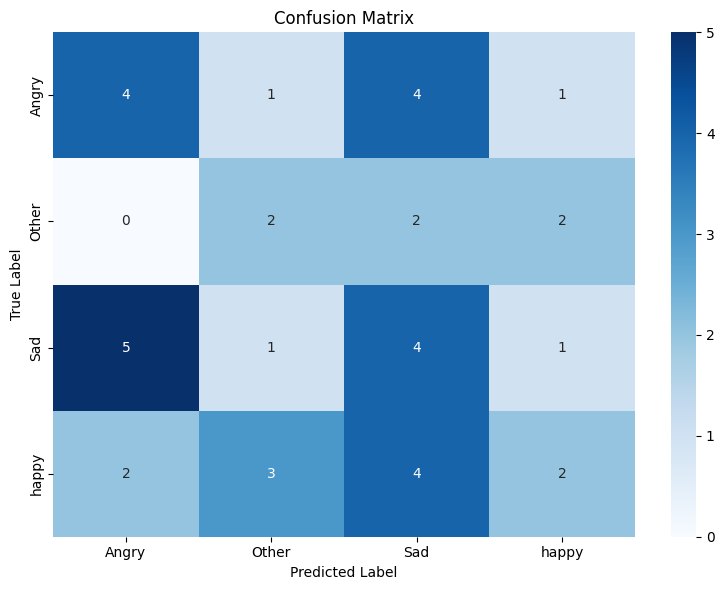

In [17]:
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
